## Image Segmentation with GrabCut

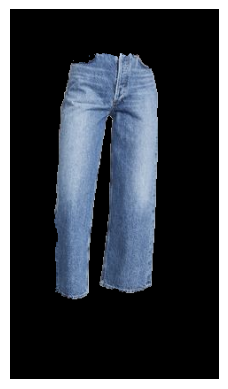

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image_path = '/content/drive/MyDrive/Clothing/jeans/Jeans_1.jpg'
def grabcut_segmentation(image_path):
    img = cv2.imread(image_path)
    mask = np.zeros(img.shape[:2], np.uint8)

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    rect = (50, 50, img.shape[1]-100, img.shape[0]-100)

    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return img

# path to the image we want to segment
image_path = '/content/drive/MyDrive/Clothing/jeans/Jeans_1.jpg'

# Perform segmentation
segmented_img = grabcut_segmentation(image_path)

# Save the segmented image
cv2.imwrite('segmented_image.jpg', segmented_img)

In [ ]:
pip install tensorflow numpy matplotlib scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the dataset directory
data_dir = '/content/drive/MyDrive/Clothing'

# ImageDataGenerator with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# ImageDataGenerator for the validation set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Prefetching data
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(train_generator.class_indices)), dtype=tf.float32)
    )
).prefetch(buffer_size=AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(validation_generator.class_indices)), dtype=tf.float32)
    )
).prefetch(buffer_size=AUTOTUNE)

Found 45 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Save the fine-tuned model
model.save('fine_tuned_vgg16.h5')

Epoch 1/10
2/2 [==============================] - 34s 13s/step - loss: 2.1681 - accuracy: 0.1778 - val_loss: 2.7303 - val_accuracy: 0.4000
Epoch 2/10
2/2 [==============================] - 37s 28s/step - loss: 2.3631 - accuracy: 0.3778 - val_loss: 1.8612 - val_accuracy: 0.4000
Epoch 3/10
2/2 [==============================] - 32s 13s/step - loss: 1.6154 - accuracy: 0.4222 - val_loss: 1.5762 - val_accuracy: 0.4000
Epoch 4/10
2/2 [==============================] - 32s 23s/step - loss: 1.2486 - accuracy: 0.5333 - val_loss: 1.1159 - val_accuracy: 0.6000
Epoch 5/10
2/2 [==============================] - 32s 13s/step - loss: 1.1070 - accuracy: 0.5333 - val_loss: 0.9682 - val_accuracy: 0.6000
Epoch 6/10
2/2 [==============================] - 32s 13s/step - loss: 0.8021 - accuracy: 0.7556 - val_loss: 1.1817 - val_accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 32s 12s/step - loss: 0.8487 - accuracy: 0.6222 - val_loss: 1.2432 - val_accuracy: 0.5000
Epoch 8/10
2/2 [===========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


###classifying new images

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

def classify_image(image_path, model_path):
    # Load the trained model
    model = load_model(model_path)

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Predict the class of the image
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])

    # Assuming train_generator is defined globally or passed to the function
    class_labels = list(train_generator.class_indices.keys())
    print(f'Predicted: {class_labels[class_idx]}')

# Example usage
classify_image('segmented_image.jpg', 'fine_tuned_vgg16.h5')

1/1 [==============================] - 2s 2s/step
Predicted: jeans
